# Analytics for Unstructured Data HW1

# Authors: Neel Sheth, Amanda Nguyen, Ryan Lee, Rianna Patel, Troy Austin, Aarib Mohammed

Forum Chosen: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

In [ ]:
# All packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import collections
import csv
import string
import re
import copy
from string import punctuation
from math import sqrt
from collections import Counter
from sklearn.manifold import MDS
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings('ignore')

### 1. Write a scraper to fetch messages posted in Edmunds.com discussion forums.
### 2. Fetch around 5000 posts about cars from the Entry Level Luxury forum

In [ ]:
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/Users/hp/opt/anaconda3/binchromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
driver = webdriver.Chrome('chromedriver',options=chrome_options)
url ='https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'
driver.get(url+ '/p2')
pageelement= driver.find_elements(by=By.XPATH,value='/html/body/div[1]/div[1]/div[2]/div/div/div/div/div[3]/main/div[4]/span/span//a')
urlnext =url
author = []
date = []
comment = []
comments = pd.DataFrame() 
for i in range(330,436):
    urlnext = url + '/p'+str(i)
    driver.get(urlnext)
    elements = driver.find_elements(By.CLASS_NAME, "Comment")
    for element in elements:
        author.append(element.find_element(By.CLASS_NAME, "Author").text)
        date.append(element.find_element(By.TAG_NAME, "time").text)
        comment.append(element.find_element(By.CLASS_NAME, "Item-Body").text)
comments['Author'] = author
comments['Date'] = date
comments['Comment'] = comment
comments.to_csv("final_data.csv", sep="\t")
!ls
files.download("final_data.csv")

### Task A: Once you fetch the data, test if the data support Zipf’s law econometrically. Also plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

In [ ]:
data = pd.read_csv("final_data.csv")
copied = copy.deepcopy(data)

def remove_space(s):
    return str(s).replace("\n"," ")

def removepunc(item):
    for p in punctuation:
        item = str(item).lstrip().replace(p,'')
    return item

def lowerize(x):
    return str(x).lower()

copied['Comments_clean'] = copied['Comment'].apply(remove_space).apply(removepunc).apply(lowerize)


In [ ]:
freqs = copied['Comments_clean'].str.split(expand=True).stack().value_counts()
df = freqs.reset_index()
df['rank'] = range(1, len(df) + 1)
df.columns = ['Word', 'Count', 'Rank']

top100 = df[:100]
top100['Ideal'] = 32111 / top100['Rank']

#### Does the data support Zipf's Law econometrically?

Text(0.5, 1.0, "Zipf's Law")

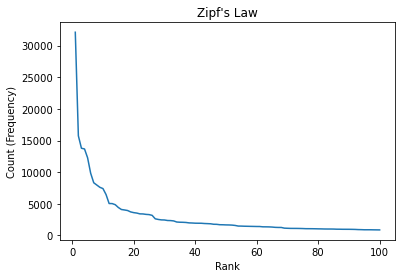

In [ ]:
plt.plot(top100['Rank'], top100['Count'])
plt.xlabel('Rank')
plt.ylabel('Count (Frequency)')
plt.title("Zipf's Law")

The data does support Zipf's Law econometrically, as the product of the frequency of words and their rank is approximately constant (up to a certain rank). This creates an "elbow" shape in the resulting graph, thus proving Zipf's law is supported by our data.

#### Most common 100 words vs. Theoretical Prediction of Zipf's Law

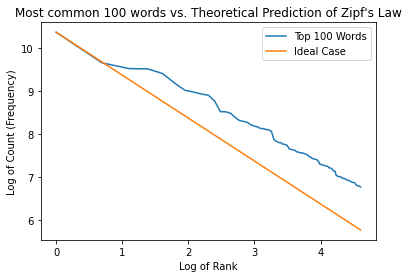

In [ ]:
plt.plot(np.log(top100['Rank']), np.log(top100['Count']), label = "Top 100 Words")
plt.plot(np.log(top100['Rank']), np.log(top100['Ideal']), label = "Ideal Case")
plt.legend()
plt.xlabel('Log of Rank')
plt.ylabel('Log of Count (Frequency)')
plt.title("Most common 100 words vs. Theoretical Prediction of Zipf's Law")
plt.show()

### Task B: Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file.

In [ ]:
brand_model = pd.read_csv('car models and brands.csv')

text = pd.read_csv('final_data.csv')
text = text.apply(lambda x: x.astype(str).str.lower())

stopwords =['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',\
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',\
            'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',\
            'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',\
            'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',\
            'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',\
            'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',\
            'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same',\
            'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',\
            've', 'y', 'ain', 'ma']

for index, row in brand_model.iterrows():
    text['Comment'] = text['Comment'].str.replace(row['Model'], row['Brand'])
    text['Comment'] = text['Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    text['Comment'] = text['Comment'].str.replace('[^\w\s]','')


C:\Users\pokem\AppData\Local\Temp\ipykernel_12572\1168371656.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  text['Comment'] = text['Comment'].str.replace('[^\w\s]','')
C:\Users\pokem\AppData\Local\Temp\ipykernel_12572\1168371656.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  text['Comment'] = text['Comment'].str.replace(row['Model'], row['Brand'])


In [ ]:
def count_brand(comment, brand): 
    count = 0
    for i in range(len(comment)):
        if brand in comment.iloc[i]:
            count += 1
    return(count)

brand_model['Brand Count'] = brand_model['Brand'].apply(lambda x: count_brand(text['Comment'], x))
brand_model = brand_model.drop_duplicates(subset=['Brand'])
brand_model = brand_model.drop('Model', axis=1)

#### Top 10 Brands

In [ ]:
brand_model.sort_values('Brand Count', ascending = False)[:11].drop(axis=0, labels=[52])

,Brand,Brand Count
410,toyota,3051
161,honda,1745
19,bmw,1722
9,audi,1439
0,acura,1381
137,ford,785
116,chrysler,767
508,volkswagen,654
359,subaru,642
319,nissan,507


### Task C: Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.

In [ ]:
text = pd.read_csv('final_data.csv')
text = text.apply(lambda x: x.astype(str).str.lower())

top_10_brands_counts = brand_model.sort_values('Brand Count', ascending = False)[:11].drop(axis=0, labels=[52])
top_10_brands = top_10_brands_counts['Brand'].values.tolist()

lift=pd.DataFrame(columns=top_10_brands)
lift['Index']=top_10_brands
lift=lift.set_index('Index')

stoplist=stopwords.words('english')
def check(X):
    if X in stoplist:
        return False
    else:
        return True
    
df2 = text.copy()
df2['Comment'] = df2['Comment'].str.replace("'", " ")
df2['Comment'] = df2['Comment'].str.strip()
df2['Stopword']=df2['Comment'].map(check) 
df2=df2[df2['Stopword']==True] 

df3=text.copy()
removed = r'\b(?:{})\b'.format('|'.join(stoplist)) 
df3['Comment']=df3['Comment'].str.replace(removed,'')
df3['Comment'] = df3['Comment'].astype(str)
df3['Comment'] = df3['Comment'].str.replace('[^\w\s]','')
df3['Final'] = df3['Comment'].apply(word_tokenize)

modelsandbrands = pd.read_csv('car models and brands.csv')
modelsandbrands = modelsandbrands.set_index("Model")

def replacemodel(X): #function to replace model name with brand name
  list_of_words=[]
  for i in X:
    if i in modelsandbrands.index.values:
      list_of_words.append(str(modelsandbrands.loc[i,'Brand']))
    else:
      list_of_words.append(i)
  return list_of_words

size_lift=int(sqrt(lift.size))

N=len(text)
i=0
j=0
for i in range(0,size_lift_matrix):
    for j in range(0,size_lift_matrix):
        A=0
        B=0
        C=0
        if i==j:
            continue
        else:
            for k in range(0,len(df_2)):
                if top_10_brands[i] in df3['Final'][k]:
                    A+=1
                if top_10_brands[j] in df3['Final'][k]:
                    B+=1
                if (top_10_brands[j] in df3['Final'][k]) and (top_10_brands[i] in df3['Final'][k]):
                    C+=1       
        lift.iat[i,j]=(N*C)/(A*B) 

,toyota,honda,bmw,audi,acura,ford,chrysler,volkswagen,subaru,nissan
Index,,,,,,,,,,
toyota,NaN,3.47954,1.724278,1.893238,1.625122,1.096141,3.944009,0.0,1.507337,1.179066
honda,3.47954,NaN,1.126102,1.231824,2.495766,0.416032,0.623716,3.555182,0.272428,0.298337
bmw,1.724278,1.126102,NaN,1.669602,0.925379,0.473788,1.03751,0.547575,0.805627,0.673938
audi,1.893238,1.231824,1.669602,NaN,1.343667,0.360617,1.338078,3.813523,0.720819,1.244506
acura,1.625122,2.495766,0.925379,1.343667,NaN,3.265291,0.595561,1.591265,1.593297,0.875381
ford,1.096141,0.416032,0.473788,0.360617,3.265291,NaN,5.669513,1.170878,0.323001,0.196511
chrysler,3.944009,0.623716,1.03751,1.338078,0.595561,5.669513,NaN,5.792763,0.532668,0.486106
volkswagen,0.0,3.555182,0.547575,3.813523,1.591265,1.170878,5.792763,NaN,0.0,0.0
subaru,1.507337,0.272428,0.805627,0.720819,1.593297,0.323001,0.532668,0.0,NaN,0.141548


#### Lift ratios for associations between the top-10 brands

In [ ]:
lift

,toyota,honda,bmw,audi,acura,ford,chrysler,volkswagen,subaru,nissan
Index,,,,,,,,,,
toyota,NaN,3.47954,1.724278,1.893238,1.625122,1.096141,3.944009,0.0,1.507337,1.179066
honda,3.47954,NaN,1.126102,1.231824,2.495766,0.416032,0.623716,3.555182,0.272428,0.298337
bmw,1.724278,1.126102,NaN,1.669602,0.925379,0.473788,1.03751,0.547575,0.805627,0.673938
audi,1.893238,1.231824,1.669602,NaN,1.343667,0.360617,1.338078,3.813523,0.720819,1.244506
acura,1.625122,2.495766,0.925379,1.343667,NaN,3.265291,0.595561,1.591265,1.593297,0.875381
ford,1.096141,0.416032,0.473788,0.360617,3.265291,NaN,5.669513,1.170878,0.323001,0.196511
chrysler,3.944009,0.623716,1.03751,1.338078,0.595561,5.669513,NaN,5.792763,0.532668,0.486106
volkswagen,0.0,3.555182,0.547575,3.813523,1.591265,1.170878,5.792763,NaN,0.0,0.0
subaru,1.507337,0.272428,0.805627,0.720819,1.593297,0.323001,0.532668,0.0,NaN,0.141548


### Task D: Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub).

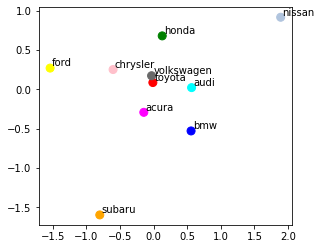

In [ ]:
lift.replace(to_replace = 0, value = np.nan, inplace=True)
dist = 1/lift_matrix
dist = dist.fillna(0)

mds = MDS(dissimilarity='precomputed', random_state=0)
X_transform = mds.fit_transform(dist)

colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'pink', 'dimgrey', 'orange', 'lightsteelblue']
size = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
brands = top_10_brands
mds_df = pd.DataFrame(X_transform, columns= ['xaxis', 'yaxis'])
mds_df['brands'] = top_10_brands
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(122)
plt.scatter(mds_df['xaxis'], mds_df['yaxis'], s=size, c=colors)

for i in range(mds_df.shape[0]):
  plt.text(x=mds_df.xaxis[i]+0.025, y=mds_df.yaxis[i]+0.025, s=mds_df.brands[i],
           fontdict=dict(color='black', size=10))

### Task E: What insights can you offer to your client from your analyses in Tasks C and D

From the MDS map, we can see that the majority of car brands are clustered toward the center of the map. We can assume that these brands could be split horizontally with the bottom half representing luxury brands such as Audi, Acura, and BMW. The top half of this cluster would represent the mainstream, reliable car brands like Toyota, Volkswagen, Honda, Ford, and a possible outlier of Chrysler. Chrysler was formerly a mainstream brand but has now tried to move itself into the luxury marketplace. This would indicate that consumers would still consider Chrysler a non luxury brands despite the company trying to change the perception of the brand. 

### Task F: What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

In [ ]:
attributes = ['performance','luxury','maintenance', 'reliability', 'durability']
df_attributes=pd.DataFrame(columns=attributes)
df_attributes['Index']=top_10_brands
df_attributes=df_attributes.set_index('Index')

size_attributes_rows=int(len(list_of_brands)) 
size_attributes_columns=int(len(attributes)) 

i=0
j=0
for i in range(0,size_attributes_rows):
    for j in range(0,size_attributes_columns):
        A=0
        B=0
        C=0
        for k in range(0,len(df3)):
            if list_of_brands[i] in df3['Final'][k]:
                A+=1
            if attributes[j] in df3['Final'][k]:
                B+=1
            if (list_of_brands[i] in df3['Final'][k]) and (attributes[j] in df3['Final'][k]):
                C+=1       
        df_attributes.iat[i,j]=(N*C)/(A*B) 

#### 5 most frequently mentioned attributes and their lift values for the top 10 most common brands

In [ ]:
df_attributes

,performance,luxury,maintenance,reliability,durability
Index,,,,,
toyota,1.12155,1.746394,3.097755,4.970256,2.293964
honda,1.024775,1.827805,1.791588,1.789683,0.870657
bmw,1.466674,1.559196,1.586673,1.638999,1.609199
audi,1.544575,1.852898,1.561442,2.490464,3.00931
acura,0.940881,1.378497,1.202846,1.241259,1.039194
ford,0.623083,0.714434,0.737561,0.573491,0.191164
chrysler,1.027541,1.309099,0.364898,2.522019,2.837272
volkswagen,0.0,1.865466,5.199803,0.0,13.477041
subaru,0.80786,1.143581,0.478143,0.826179,1.239268


### Task G: What advice will you give to your client from Task F? For this assignment, you can assume that all sentiments are positive.

The advice I would give is that potential customers have high desire for performance, luxury, maintenance, reliability, and durability, when looking at the best cars. Some brands, like BMW and Audi, have high lift values for all five of these desires, meaning that customers will probably look towards these brands when looking at luxury cars. Volkswagon has very high lift values for luxury, maintenance, and durability, but a 0 for lift value in the other categories. Ford sticks out because it has lower lift values for all of these categories, meaning that it is viewed less postively in these aspects than the other brands. Overall, our suggestion would be to assume that BMW, Audi, Volkswagon, and to a lesser extent, Acura, Subaru, and Honda, have high associations with the most sought after attributes in luxury cars.

### Task H: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [ ]:
aspiration = ['dream', 'aspire', 'hope', 'want', 'future']

def aspiring(s):
    for word in s:
        if word in aspiration:
            word = s.replace(word, 'aspiration')
    return s
df3['Aspiration'] = df3['Comment'].apply(aspiring)

aspiration_df = pd.DataFrame(columns = aspiration)
def aspiring_mentioned(x):
    if 'aspiration' in x:
        return 1
    else:
        return 0

for x in aspiration:
    aspiration_df[x] = df3['Aspiration'].apply(aspiring_mentioned)
    
df_aspiration=pd.DataFrame(columns=aspiration)
df_aspiration['Index']=top_10_brands
df_aspiration=df_aspiration.set_index('Index')
        
size_aspiration_rows=int(len(list_of_brands)) 
size_aspiration_columns=int(len(aspiration)) 

i=0
j=0
for i in range(0,size_aspiration_rows):
    for j in range(0,size_aspiration_columns):
        A=0
        B=0
        C=0
        for k in range(0,len(df3)):
            if list_of_brands[i] in df3['Final'][k]:
                A+=1
            if "aspiration" in df3['Final'][k]:
                B+=1
            if (list_of_brands[i] in df3['Final'][k]) and ("aspiration" in df3['Final'][k]):
                C+=1       
        df_aspiration.iat[i,j]=(N*C)/(A*B)
df_aspiration.drop(columns=['future', 'want', 'hope', 'aspire'], inplace=True)
df_aspiration.rename(columns={"dream":"aspiration"}, inplace=True)

#### Which is the most aspirational brand in your data in terms of people actually wanting to buy or own?

In [ ]:
df_aspiration

,aspiration
Index,
toyota,0.0
honda,7.110363
bmw,4.380597
audi,5.084697
acura,4.243373
ford,0.0
chrysler,0.0
volkswagen,0.0
subaru,20.241379


The most aspirational brand is Subaru, it has the highest aspiration lift value.

#### Describe your analysis. What are the business implications for this brand?

For the sentiment analysis, we used words such as 'dream', 'aspire', 'hope', 'want', and 'future' to determine which brand would be considered the most aspirational out of the dataset. Subaru has the highest aspirational value which is unexpected because the brand isn't traditionally known as people's dream car. Subara could be perceived as a brand that provides a cheaper and reliable car that also has comes with really great features for the price that you're paying, and this could  explain why the brand is doing much better in this analysis than some would suspect. Subaru could use this data to determine that their brand is becoming much more trusted and desired in the market so they should continue to go forward with their exising brand strategy.